[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1F8RLGuh8UMgDPx3GTn6OZfNb9waPTjtN?usp=sharing)


In [1]:
!pip install scikit-fda
!pip install scipy --upgrade

     |████████████████████████████████| 286kB 7.6MB/s 
     |████████████████████████████████| 4.0MB 11.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for fdasrsf: filename=fdasrsf-2.2.8-cp37-cp37m-linux_x86_64.whl size=1495097 sha256=816c1349ae8b629f8207ea2bd6bc795833091b191b555b525f57f98f325bb440
  Stored in directory: /root/.cache/pip/wheels/88/fc/7f/f2daafc54865a0eb85d5e1fa3a5ea1b5b1b2a62d60a020df59
Successfully built fdasrsf
  Created wheel for findiff: filename=findiff-0.8.9-cp37-none-any.whl size=29219 sha256=9d1a030b473c9738ac3468330df20f3e8fd3de63a0807b8ecbe3b4216c6cc619
  Stored in directory: /root/.cache/pip/wheels/11/24/9f/5f0a2414302f708f5cac01fede118615cb3679437787f1632f
Successfully built findiff
     |████████████████████████████████| 27.4MB 156kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  

In [2]:
import skfda
import skfda.preprocessing.smoothing.kernel_smoothers as ks
import skfda.preprocessing.smoothing.validation as val
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.preprocessing.smoothing import BasisSmoother

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
import random
import plotly.express as px
from tqdm.notebook import tqdm

# Data exploration and experiments

In this part we will look at the data, perform cross-validation for the smoothing parameter and find outliers

## Data preparation

In [17]:
# load data
df = pd.read_csv('open_face_short.csv', sep='\t', index_col=[0,1])
df.head()

confidence  pose_Rx  ...  speaker   sentence
video_name          frame                       ...                    
gen_q-dev_upala-alt 0            0.98    0.067  ...      alt  dev_upala
                    1            0.98    0.083  ...      alt  dev_upala
                    2            0.98    0.088  ...      alt  dev_upala
                    3            0.98    0.101  ...      alt  dev_upala
                    4            0.98    0.114  ...      alt  dev_upala

[5 rows x 7 columns]

The columns are:
*   pose_Rx, inner_perp_dist39_42_3d_pred_mlp_8_diff, outer_perp_dist39_42_3d_pred_mlp_8_diff - vertical head rotation angle, inner eyebrows distance and outer eyebrows distance
*   confidence - confidence of the OpenFace model for the frame
*   sType - sentence type
*   speaker - speaker id
*   sentence - sentence id

In [18]:
# drop frames with low score and fill in neighboring values (if a NaN is in the middle fill in the mean of the neighboring values)
low_confidence_videos = np.unique(df.loc[df.confidence < 0.8].index.get_level_values(0))
print('Number of videos with low confidence frames:', len(low_confidence_videos))
print('Number of frames with low confidence:', sum(df.confidence < 0.8))

df.loc[df.confidence < 0.8, ['inner_perp_dist39_42_3d_pred_mlp_8_diff','outer_perp_dist39_42_3d_pred_mlp_8_diff','pose_Rx']] = None
bfill = df[['inner_perp_dist39_42_3d_pred_mlp_8_diff','outer_perp_dist39_42_3d_pred_mlp_8_diff','pose_Rx']].bfill(axis=0)
ffill = df[['inner_perp_dist39_42_3d_pred_mlp_8_diff','outer_perp_dist39_42_3d_pred_mlp_8_diff','pose_Rx']].ffill(axis=0)
df[['inner_perp_dist39_42_3d_pred_mlp_8_diff','outer_perp_dist39_42_3d_pred_mlp_8_diff','pose_Rx']] = (bfill + ffill)/2

Number of videos with low confidence frames: 14
Number of frames with low confidence: 106


We turn df data into separate lists/arrays for convenience

In [19]:
video_names = df.index.levels[0].unique()
l = video_names.shape[0]
print(l)

259


We will explore one value right now - inner eyebrow distance 

In [20]:
of_list = []
for video_name in video_names:
    data = df.loc[video_name, 'inner_perp_dist39_42_3d_pred_mlp_8_diff']
    of_list.append(data.values)

In [21]:
len(of_list)

259

In [22]:
frameids = []
for video_name in video_names:
    data = df.loc[video_name].index
    frameids.append(data.values)

In [23]:
sentence_type = []
speaker_ids = []
sentences = []
durations = []
for video_name in video_names:
    sentence_type.append(df.loc[video_name, 'sType'].iloc[0])
    speaker_ids.append(df.loc[video_name, 'speaker'].iloc[0])
    sentences.append(df.loc[video_name, 'sentence'].iloc[0])
    durations.append(df.loc[video_name].index.values.max())
sentence_type = np.asarray(sentence_type)
speaker_ids = np.asarray(speaker_ids)
sentences = np.asarray(sentences)

All sentences will be normalized to be the same length (mean duration)

In [25]:
norm_rng = (0, np.mean(durations))

Make fda objects for all sentences. Although skfda.FDataGrid allows multidimensional input, we can't use that functionality because sentences have different number of frames.

In [26]:
fds = []
for i, video_name in enumerate(video_names):
    # normalize frame ids
    t_norm = (frameids[i] / (durations[i])) * np.mean(durations)
    fd = skfda.FDataGrid(
        data_matrix=of_list[i],
        grid_points=t_norm,
    )
    fds.append(fd)

## Smoothing

### Smoothers cross-validation

There are two options available in skfda for smoothers - kernal and basis smoothers - [see documentation for more](https://fda.readthedocs.io/en/latest/modules/preprocessing/smoothing.html)

We will cross-validate smoothing options and see which performs best

#### Kernel Smoothers

For kernel smoothers there are two parameters either n_neighbors (for KNeighbors smoother) or bandwidth (for others).

In [ ]:
n_neighbors = np.arange(1, 10)

In [ ]:
bandwidth = np.arange(1,10,0.5)

Obtain mean scores for the parameters

In [ ]:
mean_scores = defaultdict(lambda: defaultdict(list))
for fd in fds:
    # K-nearest neighbours kernel smoothing.
    knn = val.SmoothingParameterSearch(
        ks.KNeighborsSmoother(),
        n_neighbors,
    )
    knn.fit(fd)
    mean_scores['knn'][knn.best_params_['smoothing_parameter']].append(knn.best_score_)

    # Local linear regression kernel smoothing.
    llr = val.SmoothingParameterSearch(
        ks.LocalLinearRegressionSmoother(),
        bandwidth,
    )
    llr.fit(fd)
    mean_scores['llr'][llr.best_params_['smoothing_parameter']].append(llr.best_score_)

    # Nadaraya-Watson kernel smoothing.
    nw = val.SmoothingParameterSearch(
        ks.NadarayaWatsonSmoother(),
        bandwidth,
    )
    nw.fit(fd)
    mean_scores['nw'][nw.best_params_['smoothing_parameter']].append(nw.best_score_)

/usr/local/lib/python3.7/dist-packages/skfda/preprocessing/smoothing/validation.py:109: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/skfda/preprocessing/smoothing/validation.py:104: RuntimeWarning:

divide by zero encountered in double_scalars



In [ ]:
param_mean = defaultdict(dict)
for kernel, scores in mean_scores.items():
    for param, test_scores in scores.items():
        param_mean[kernel][param] = np.mean(test_scores)

Look at the most frequent best smoothers

In [ ]:
param_freq = defaultdict(dict)
for kernel, scores in mean_scores.items():
    for param, test_scores in scores.items():
        param_freq[kernel][param] = len(test_scores)
for kernel, scores in param_freq.items():
    print(kernel)
    for top in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:5]:
        print('\t', top)

knn
	 (3, 144)
	 (5, 46)
	 (9, 25)
	 (4, 15)
	 (6, 12)
llr
	 (9.5, 63)
	 (3.0, 28)
	 (3.5, 22)
	 (4.0, 21)
	 (2.5, 21)
nw
	 (1.0, 75)
	 (1.5, 65)
	 (2.0, 36)
	 (2.5, 22)
	 (9.5, 21)


Look at the scores of the best smoothers

In [ ]:
for kernel, scores in param_mean.items():
    print(kernel)
    for top in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]:
        print('\t', top, param_freq[kernel][top[0]])

knn
	 (2, -0.17808094729007504) 3
	 (7, -0.2735285901906562) 10
	 (8, -0.35613238979394685) 4
	 (5, -0.40604270881765947) 46
	 (9, -0.42508194223040724) 25
	 (6, -0.4379677340663844) 12
	 (3, -0.46494594936930167) 144
	 (4, -0.6645630136559431) 15
llr
	 (9.0, -0.39593113796022117) 5
	 (6.5, -0.3961048765247182) 7
	 (7.5, -0.4377152794840477) 9
	 (1.5, -0.5410493090065007) 4
	 (3.0, -0.595503329661596) 28
	 (4.0, -0.625730069495601) 21
	 (2.5, -0.6346729662023411) 21
	 (5.5, -0.6453638328169828) 12
	 (6.0, -0.6793940134742351) 8
	 (9.5, -0.7258855562965525) 63
nw
	 (7.0, -0.13676605568380085) 2
	 (6.0, -0.17535117116278465) 1
	 (3.5, -0.20718802460273228) 7
	 (9.0, -0.25231520339922514) 1
	 (8.5, -0.2600724505904106) 3
	 (5.0, -0.2942426287951469) 3
	 (9.5, -0.39713193240314865) 21
	 (1.0, -0.4623041441351621) 75
	 (3.0, -0.487052272359693) 9
	 (1.5, -0.6049707908589262) 65


#### Basis smoother

Basis smoother has smoothing parameter lambda and number of basis functions and their order

In [27]:
lambda_ = np.logspace(0,2,3)

In [ ]:
nbasis = np.arange(5, 18)
norder = np.arange(3, 11)

In [ ]:
logs = {}
param_product = list(product(nbasis, norder))
print(len(param_product))
for b, o in tqdm(param_product):
    # order of the basis functions should not be higher than the number of basis functions
    if o - b > 0:
        continue
    best_params = []
    scores = []
    fds_basis = []
    basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=b, order=o)
    smoother = val.SmoothingParameterSearch(
            BasisSmoother(basis=basis),
            lambda_,
        )
    for i, fd in enumerate(fds):
        try:
            smoother.fit(fd)
            basis = smoother.best_estimator_
            basis.set_params(return_basis=True)
            fd_basis = basis.transform(fd)
            fds_basis.append(fd_basis)
            scores.append(smoother.best_score_)
            best_params.append(smoother.best_params_['smoothing_parameter'])
        except Exception as e:
            break
    logs[(b,o)] = {'best_params': best_params, 'fds_basis': fds_basis, 'scores': scores}

117


In [ ]:
logs_basis = logs

In [ ]:
# sometimes basis transformation fails (often when there are missing values or outliers - that is why we filled in low confidence scores)
successful = {params: log for params, log in logs.items() if len(log['scores']) == 259}

In [ ]:
len(logs), len(successful)

(102, 102)

In [ ]:
logs.keys()

dict_keys([(5, 2), (5, 3), (5, 4), (5, 5), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (12, 8), (12, 9), (12, 10), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (13, 8), (13, 9), (13, 10), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (14, 8), (14, 9), (14, 10), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7), (15, 8), (15, 9), (15, 10), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10)])

Look at mean scores

In [ ]:
mean_scores = defaultdict(dict)
for (b, o), log in logs.items():
    for smoothing_parameter in np.unique(log['best_params']):
        mean_score = np.mean([score for l, score in zip(log['best_params'], log['scores']) if l == smoothing_parameter])
        mean_scores[(b,o)][smoothing_parameter] = mean_score

In [ ]:
mean_scores = {param: score[1] for param, score in mean_scores.items() if not (np.isnan(score[1]) or np.isinf(score[1]))}

In [ ]:
mean_scores = {param: score for param, score in mean_scores.items() if param[1] > 2 }

In [ ]:
sorted_scores = sorted(mean_scores.items(), key=lambda x: x[1], reverse=True)
top_basis = sorted_scores[:15]

In [ ]:
top_basis

[((15, 3), -0.9269377455669086),
 ((14, 3), -0.9335053367268428),
 ((13, 3), -0.9550588863363499),
 ((12, 3), -0.9683005193893205),
 ((16, 3), -0.9750805848516251),
 ((11, 3), -0.9935142105408821),
 ((10, 3), -1.0389461091124295),
 ((9, 3), -1.0790393744416809),
 ((17, 3), -1.0974001957062625),
 ((13, 4), -1.1131980264267156),
 ((12, 4), -1.1178797559370957),
 ((11, 4), -1.131648185344319),
 ((8, 3), -1.1428171508339346),
 ((14, 4), -1.149217583252189),
 ((10, 4), -1.1564979905639348)]

Plot 4 random sentences with basis functions

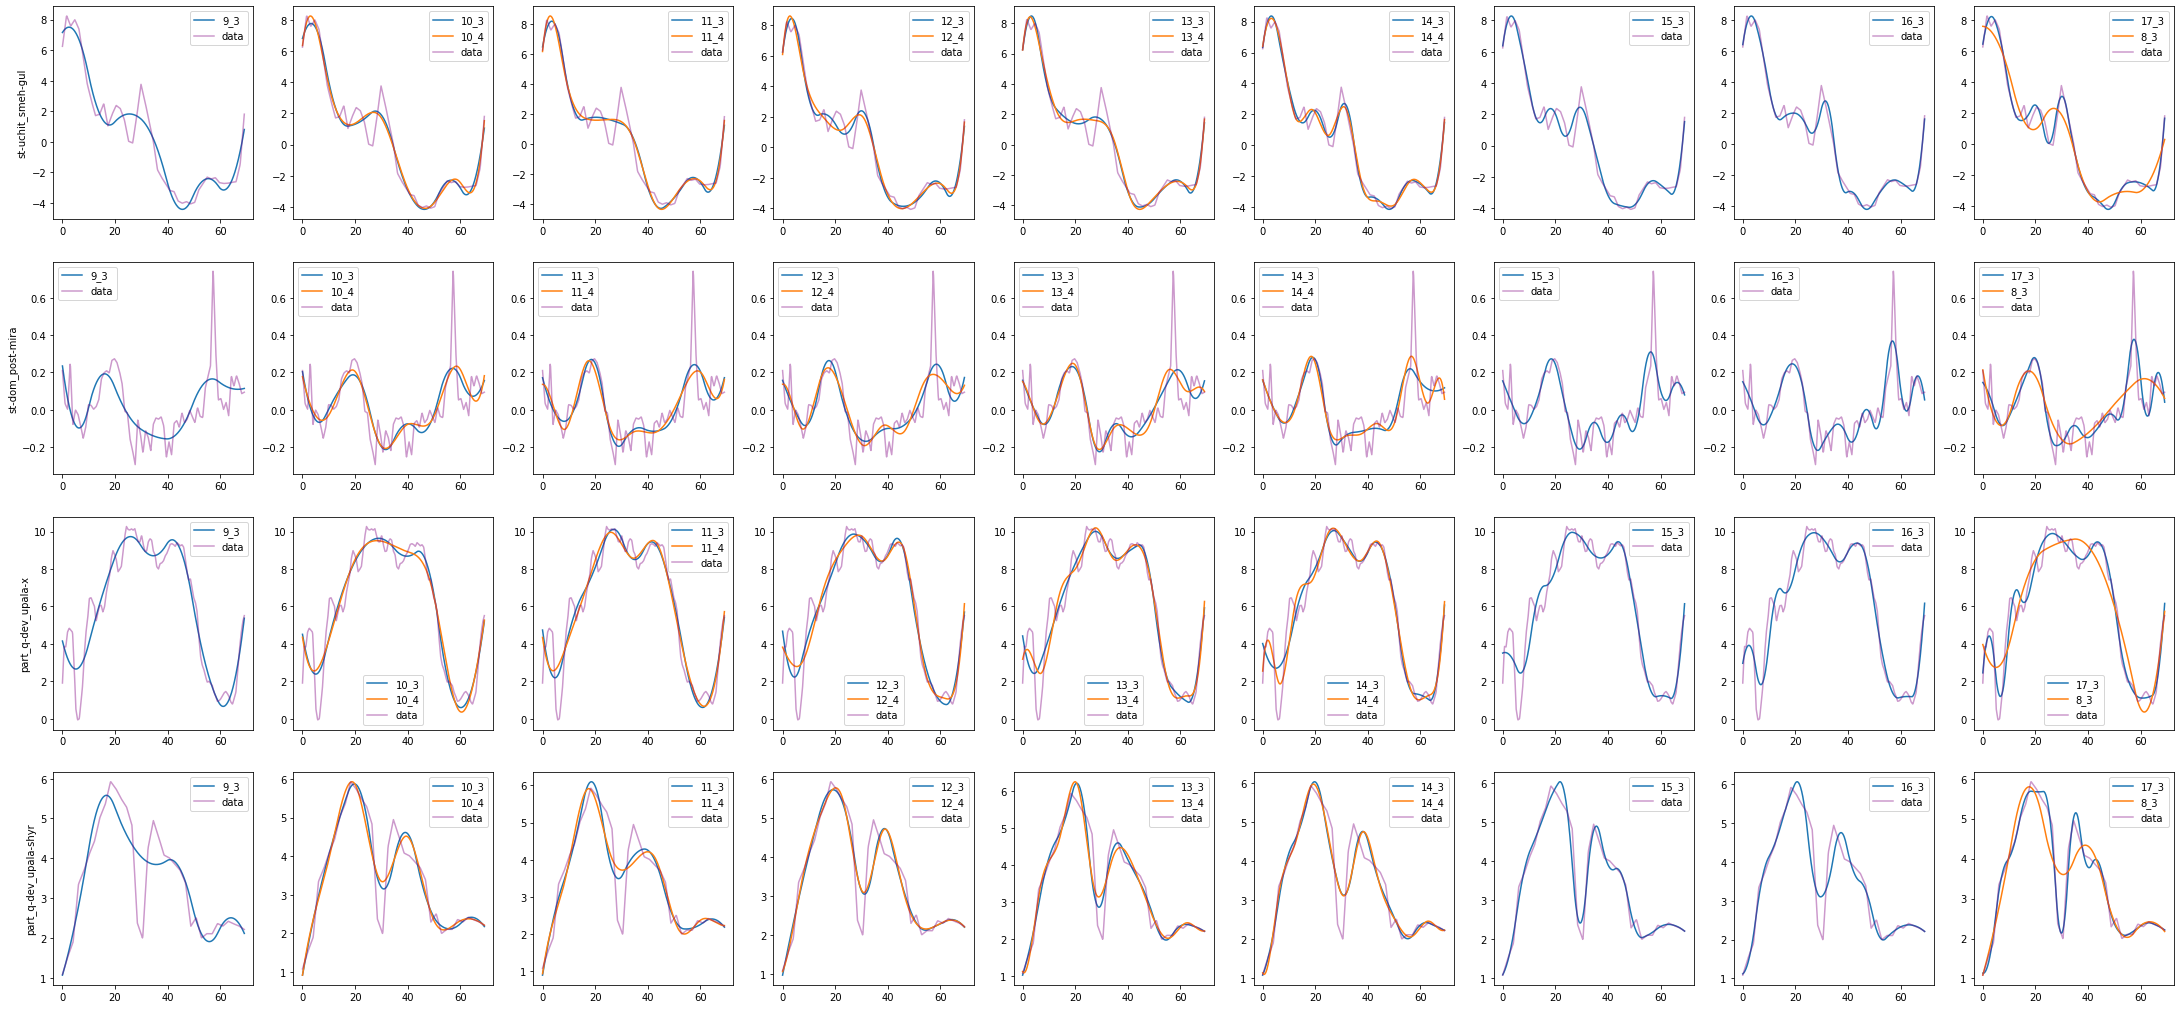

In [ ]:
fig, axes = plt.subplots(4, 9, figsize=(38,18))
for i in range(4):
    ix = random.randint(0, l)
    fd = fds[ix]
    for (b, o), _ in top:
        fd_basis = logs[(b,o)]['fds_basis'][ix]
        fd_basis.plot(axes=axes[i][(b-9)%9], label=f'{b}_{o}')
    for ax in axes[i].flatten():
        fd.plot(axes=ax, color='purple', alpha=0.4, label='data')
        ax.legend()
    axes[i][0].set_ylabel(video_names[ix])

Manually pick best parameters and plot their estimations

In [ ]:
top = [
 (15, 3),
 (14, 3),
 (13, 3),
 (12, 3),
 (16, 3),
 (11, 3),
]

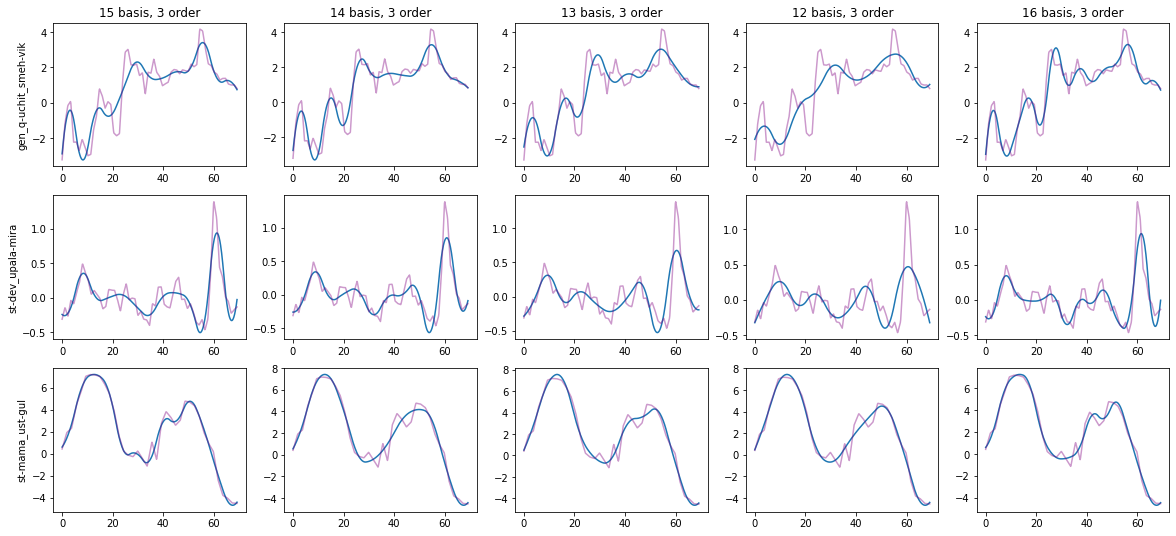

In [ ]:
n_top = 5
n = 3
fig, axes = plt.subplots(n, n_top, figsize=(n_top*4,n*3))
for i in range(n):
    ix = random.randint(0, l)
    fd = fds[ix]
    for j, (b, o) in enumerate(top[:n_top]):
        basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=b, order=o)
        fd_basis = fd.to_basis(basis)
        fd_basis.plot(axes=axes[i][j], label=f'{b}_{o}')
        axes[0][j].set_title(f'{b} basis, {o} order')
    for ax in axes[i].flatten():
        fd.plot(axes=ax, color='purple', alpha=0.4, label='data')
    axes[i][0].set_ylabel(video_names[ix])

### Look at the best smoothers

Pick a random sentence and plot all best smoothers

In [ ]:
ix = random.randint(0, l)
fd = fds[ix]
print(ix, video_names[ix])

108 part_q-mal_chit-x


For kernel smoother we also need to pick the number of basis functions and their order

#### KNeighbors 3

In [ ]:
smoother = ks.KNeighborsSmoother(smoothing_parameter=3)
fds_smooth = []
for fd in fds:
    fd_smooth = smoother.fit_transform(fd)
    fds_smooth.append(fd_smooth)

##### Find not crusing parameters for kernel smoothers

In [ ]:
nbasis = np.arange(3, 25)
norder = np.arange(3, 15)

In [ ]:
logs = {}
for b, o in product(nbasis, norder):
    if o - b > 0:
        continue
    basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=b, order=o)
    success = []
    for i, fd_smooth in enumerate(fds_smooth):
        try:
            fd_basis = fd_smooth.to_basis(basis)
            success.append(i)
        except Exception as e:
            break
    logs[(b,o)] = success

In [ ]:
successful = {params: log for params, log in logs.items() if len(log) == 259}

In [ ]:
len(logs), len(successful)

(198, 198)

In [ ]:
successful.keys()

dict_keys([(3, 3), (4, 3), (4, 4), (5, 3), (5, 4), (5, 5), (6, 3), (6, 4), (6, 5), (6, 6), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (12, 8), (12, 9), (12, 10), (12, 11), (12, 12), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (13, 8), (13, 9), (13, 10), (13, 11), (13, 12), (13, 13), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7), (15, 8), (15, 9), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (

Plot smoother

Text(0.5, 0.98, 'part_q-mal_chit-x')

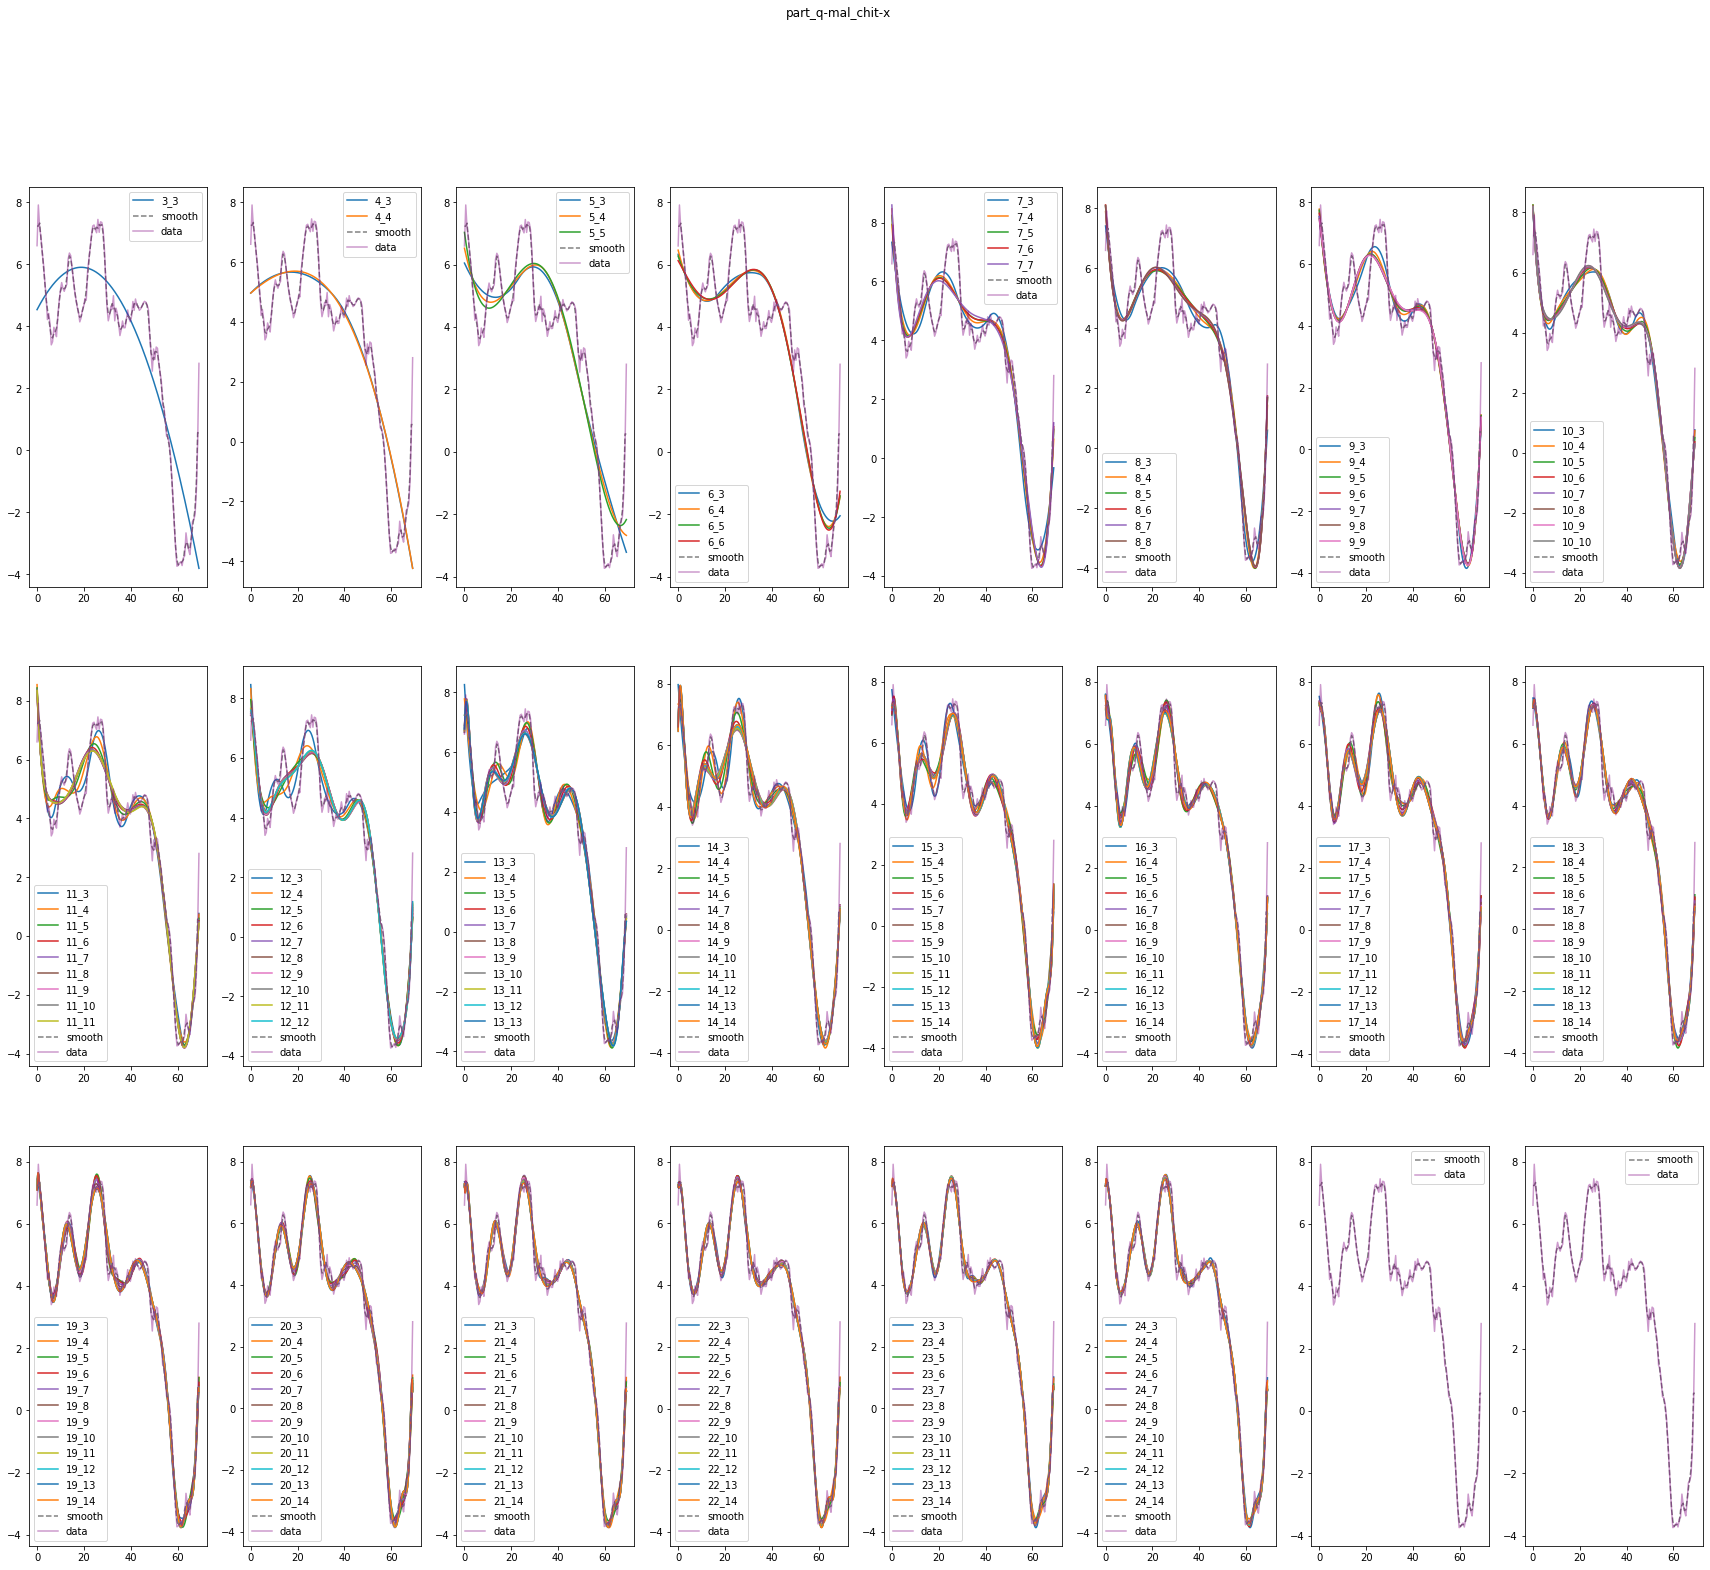

In [ ]:
fig, axes = plt.subplots(3, 8, figsize=(30,25))
fd_smooth = fds_smooth[ix]
for i, (b, o) in enumerate(successful.keys()):
    basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=b, order=o)
    fd_basis = fd_smooth.to_basis(basis)
    fd_basis.plot(axes=axes[(b-3)//8][(b-3)%8], label=f'{b}_{o}')
for ax in axes.flatten():
    # ax.set_yscale('log')
    fd_smooth.plot(axes=ax, color='grey', linestyle='--', label='smooth')
    fd.plot(axes=ax, color='purple', alpha=0.4, label='data')
    ax.legend()
fig.suptitle(video_names[ix])

#### NadarayaWatson 1.5

In [ ]:
smoother = ks.NadarayaWatsonSmoother(smoothing_parameter=1.5)
fds_smooth = []
for fd in fds:
    fd_smooth = smoother.fit_transform(fd)
    fds_smooth.append(fd_smooth)

In [ ]:
norm_rng = (0,np.mean(durations))
nbasis = np.arange(3, 25)
norder = np.arange(3, 15)

Find not crashing parameters

In [ ]:
logs = {}
for b, o in product(nbasis, norder):
    if o - b > 0:
        continue
    basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=b, order=o)
    success = []
    for i, fd_smooth in enumerate(fds_smooth):
        try:
            fd_basis = fd_smooth.to_basis(basis)
            success.append(i)
        except Exception as e:
            continue
    logs[(b,o)] = success

In [ ]:
successful = {params: log for params, log in logs.items() if len(log) == 259}

In [ ]:
len(logs), len(successful)

(198, 48)

In [ ]:
successful.keys()

dict_keys([(3, 3), (4, 3), (4, 4), (5, 3), (5, 4), (5, 5), (6, 3), (6, 4), (6, 5), (6, 6), (7, 4), (7, 5), (7, 6), (7, 7), (8, 5), (8, 6), (8, 7), (8, 8), (9, 6), (9, 7), (9, 8), (9, 9), (10, 7), (10, 8), (10, 9), (10, 10), (11, 8), (11, 9), (11, 10), (11, 11), (12, 9), (12, 10), (12, 11), (12, 12), (13, 10), (13, 11), (13, 12), (13, 13), (14, 11), (14, 12), (14, 13), (14, 14), (15, 12), (15, 13), (15, 14), (16, 13), (16, 14), (17, 14)])

Text(0.5, 0.98, 'part_q-okno_razb-x')

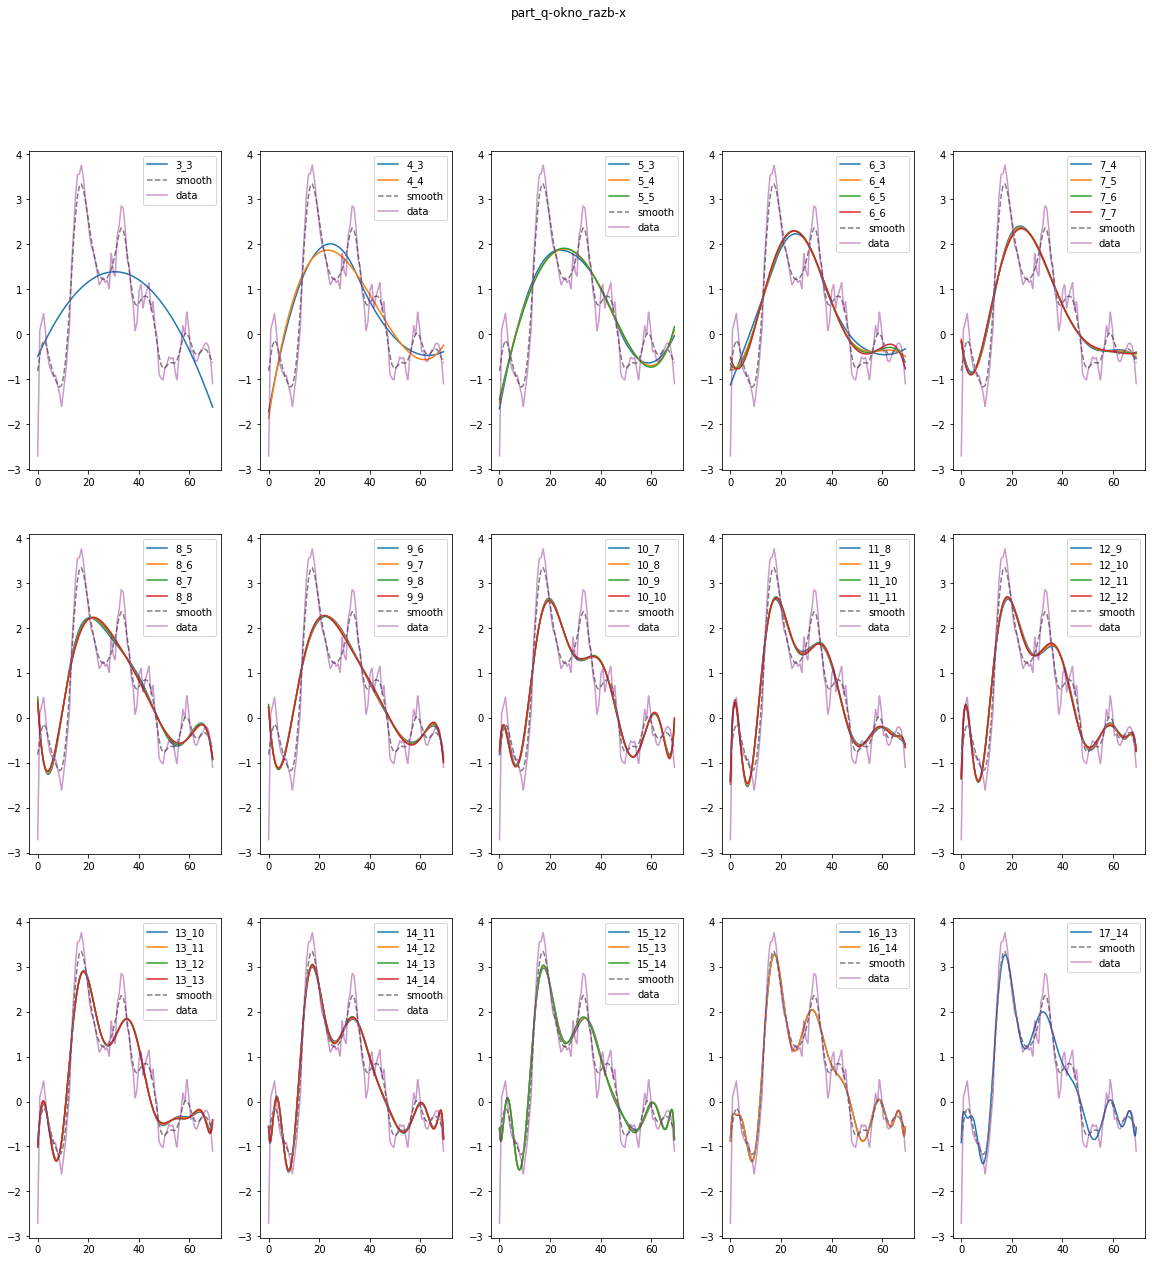

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20,20))
for i, (b, o) in enumerate(successful.keys()):
    basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=b, order=o)
    fd_basis = fd_smooth.to_basis(basis)
    fd_basis.plot(axes=axes[(b-3)//5][(b-3)%5], label=f'{b}_{o}')
for ax in axes.flatten():
    # ax.set_yscale('log')
    fd_smooth.plot(axes=ax, color='grey', linestyle='--', label='smooth')
    fd.plot(axes=ax, color='purple', alpha=0.4, label='data')
    ax.legend()
fig.suptitle(video_names[ix])

#### KNeighbors 5

In [ ]:
smoother = ks.KNeighborsSmoother(smoothing_parameter=5)
fds_smooth = []
for fd in fds:
    fd_smooth = smoother.fit_transform(fd)
    fds_smooth.append(fd_smooth)

Find not crashing parameters

In [ ]:
norm_rng = (0,np.mean(durations))
nbasis = np.arange(3, 25)
norder = np.arange(3, 15)

In [ ]:
logs = {}
for b, o in product(nbasis, norder):
    if o - b > 0:
        continue
    basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=b, order=o)
    success = []
    for i, fd_smooth in enumerate(fds_smooth):
        try:
            fd_basis = fd_smooth.to_basis(basis)
            success.append(i)
        except Exception as e:
            continue
    logs[(b,o)] = success

In [ ]:
successful = {params: log for params, log in logs.items() if len(log) == 259}

In [ ]:
len(logs), len(successful)

(198, 48)

In [ ]:
successful.keys()

dict_keys([(3, 3), (4, 3), (4, 4), (5, 3), (5, 4), (5, 5), (6, 3), (6, 4), (6, 5), (6, 6), (7, 4), (7, 5), (7, 6), (7, 7), (8, 5), (8, 6), (8, 7), (8, 8), (9, 6), (9, 7), (9, 8), (9, 9), (10, 7), (10, 8), (10, 9), (10, 10), (11, 8), (11, 9), (11, 10), (11, 11), (12, 9), (12, 10), (12, 11), (12, 12), (13, 10), (13, 11), (13, 12), (13, 13), (14, 11), (14, 12), (14, 13), (14, 14), (15, 12), (15, 13), (15, 14), (16, 13), (16, 14), (17, 14)])

Text(0.5, 0.98, 'part_q-okno_razb-x')

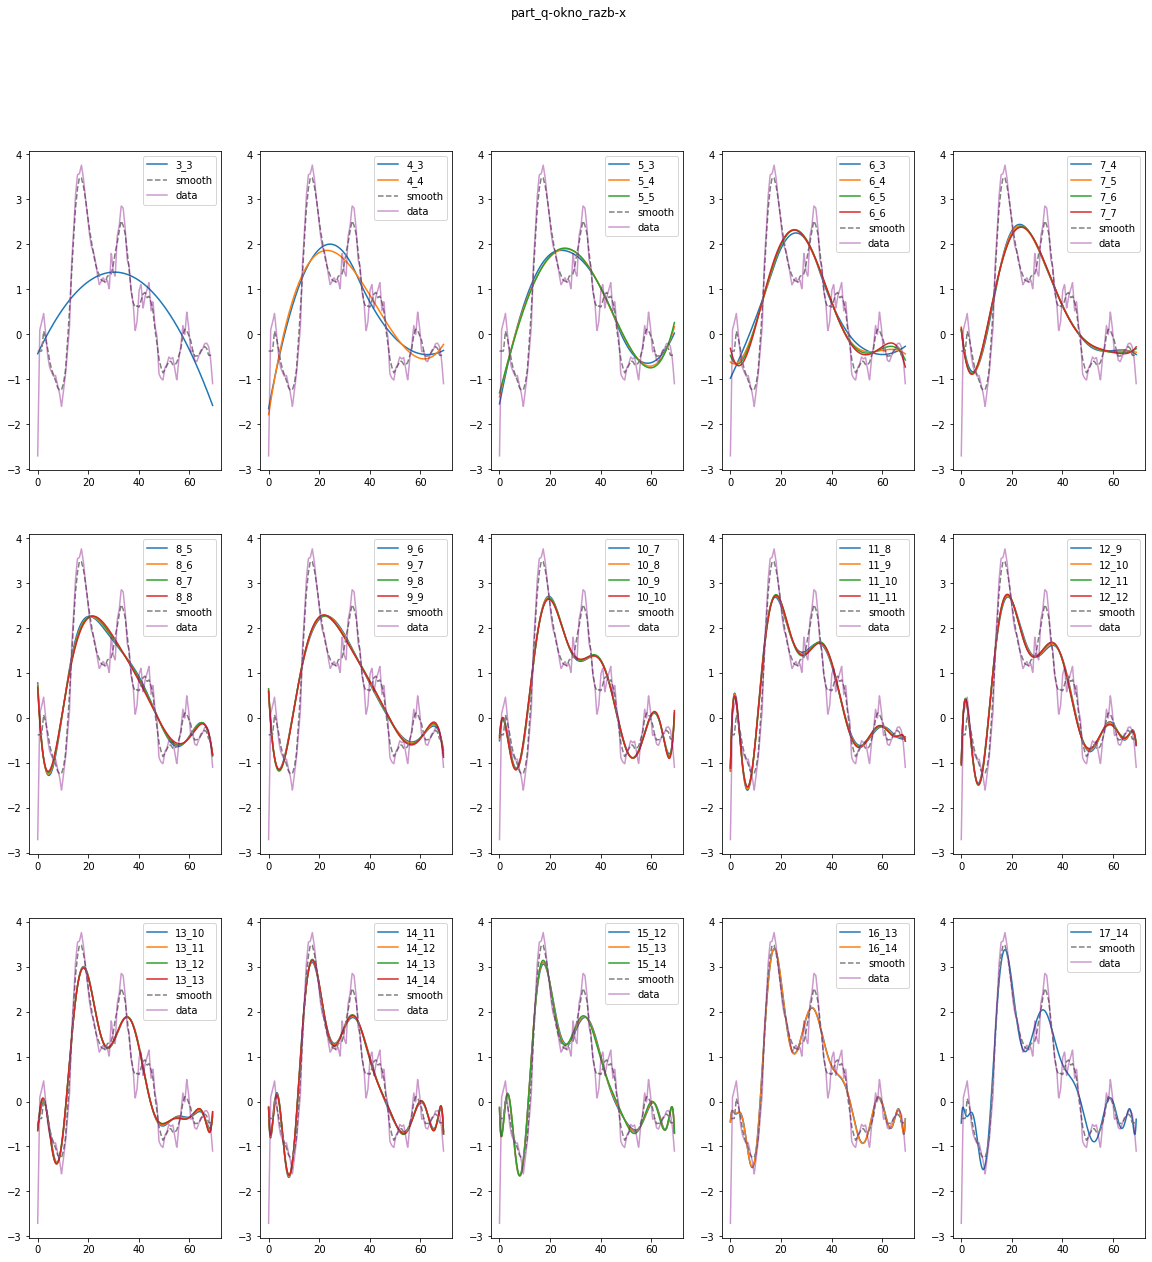

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20,20))
for i, (b, o) in enumerate(successful.keys()):
    basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=b, order=o)
    fd_basis = fd_smooth.to_basis(basis)
    fd_basis.plot(axes=axes[(b-3)//5][(b-3)%5], label=f'{b}_{o}')
for ax in axes.flatten():
    # ax.set_yscale('log')
    fd_smooth.plot(axes=ax, color='grey', linestyle='--', label='smooth')
    fd.plot(axes=ax, color='purple', alpha=0.4, label='data')
    ax.legend()
fig.suptitle(video_names[ix])

### Pick smoother

Pick a sample of videos to plot

In [ ]:
ixs = np.random.choice(np.arange(l), 9)
print(ixs)

[188 102 249 121  72  71  77 128 179]


In [ ]:
editors_pick = [(11,9),(12,10),(14,12),(16,14)]

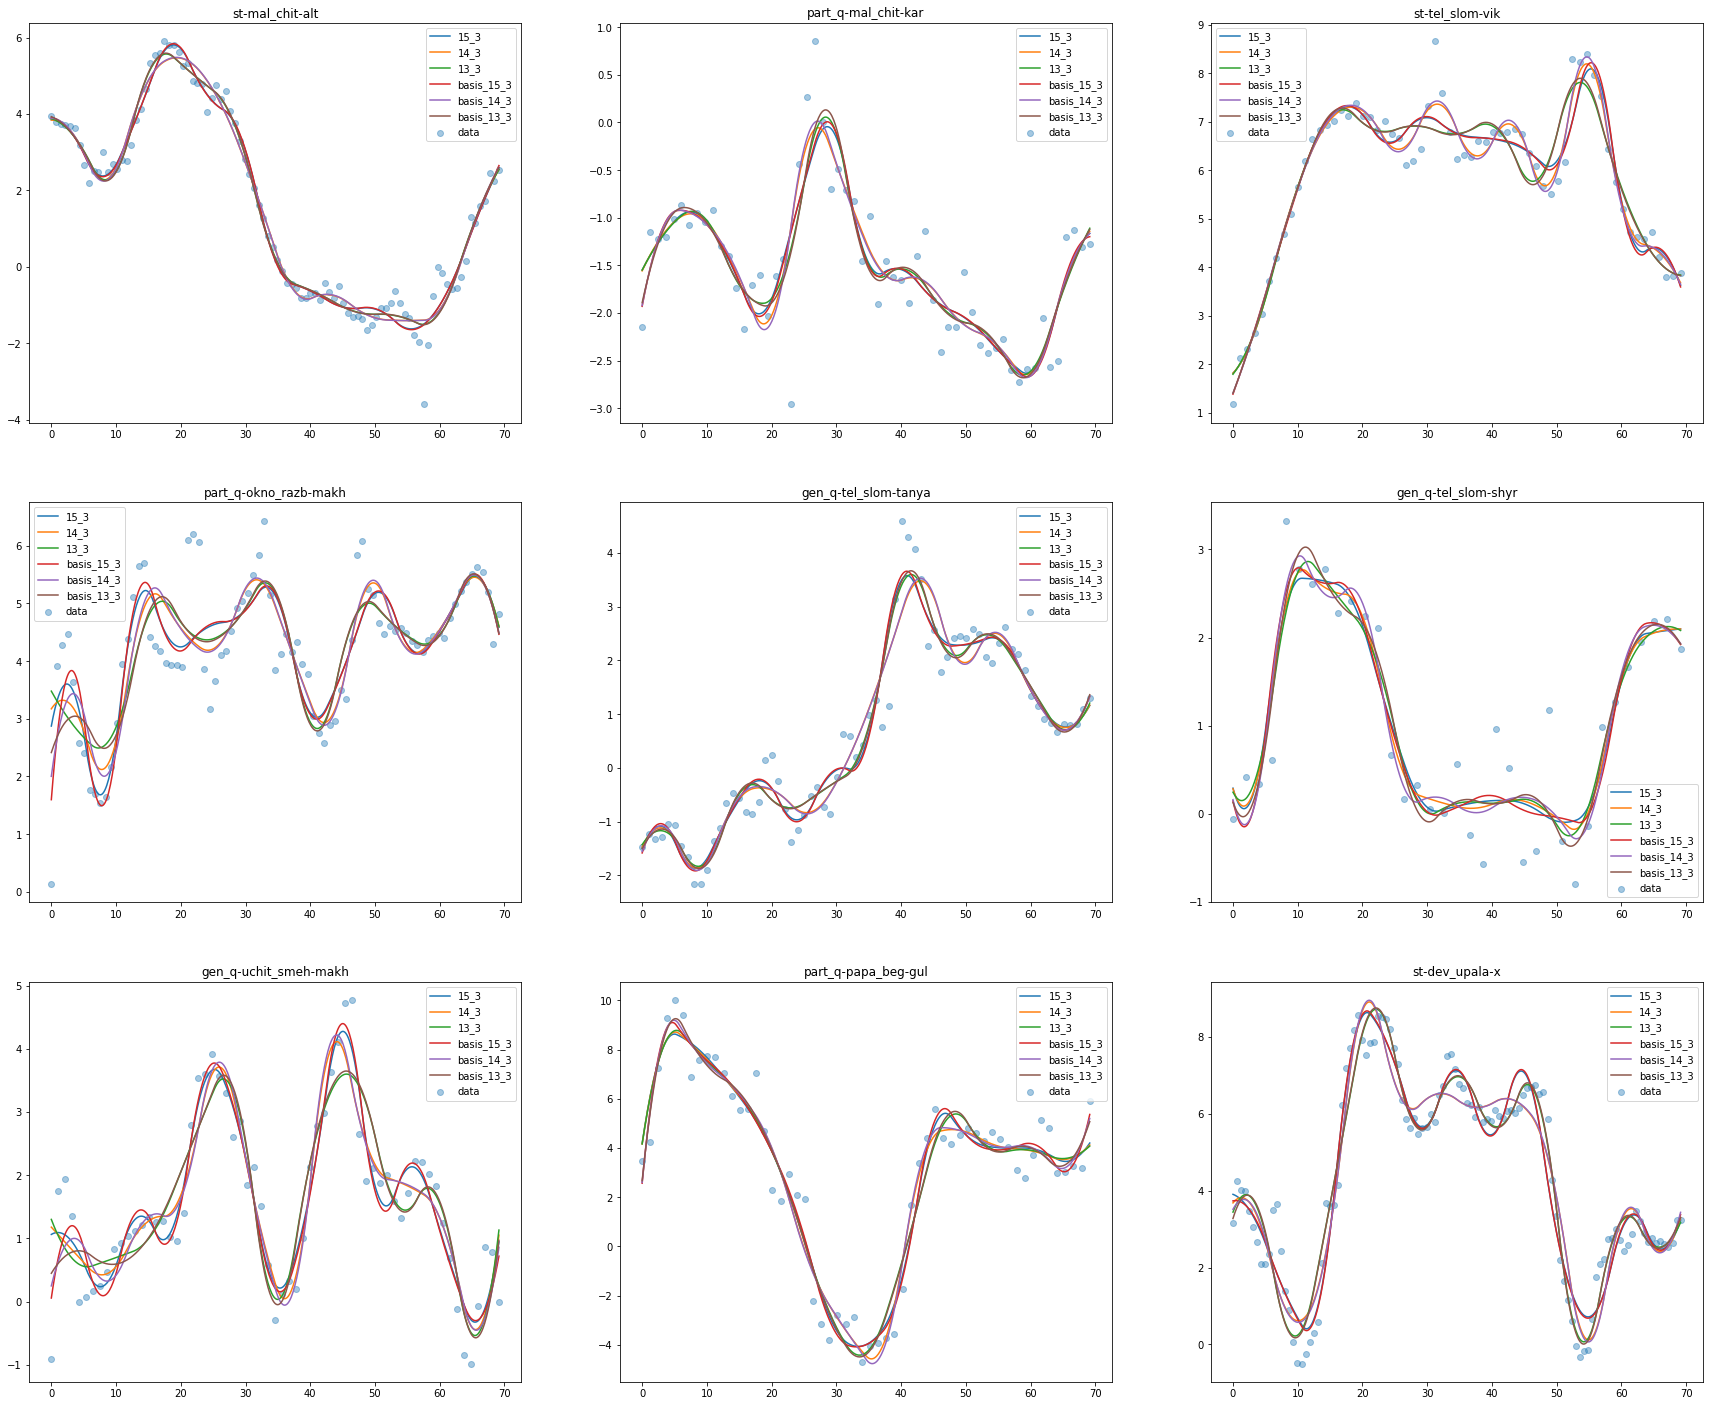

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(30,25))
axes = axes.flatten()
for i, ix in enumerate(ixs):
    fd = fds[ix]
    fd_smooth = fds_smooth[ix]
    for (b, o), _ in top_basis[:3]:
        basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=b, order=o)
        fd_basis = fd_smooth.to_basis(basis)
        fd_basis.plot(axes=axes[i], label=f'{b}_{o}')
    for (b, o), _ in top_basis[:3]:
        fd_basis = logs_basis[(b,o)]['fds_basis'][ix]
        fd_basis.plot(axes=axes[i], label=f'basis_{b}_{o}')
    # fd_smooth.plot(axes=axes[i], color='grey', linestyle='--', label='smooth')
    fd.scatter(axes=axes[i], alpha=0.4, label='data')
    axes[i].legend()
    axes[i].set_title(video_names[ix])

Looks like the smoothing of the kernel smoothers depends mostly on the number of basis functions and their order, rather than their smoothing parameter, we decided to not use them and use a basis smoother.

Let's pick basis smoother with bspline nbasis=14, norder=3, lambda=1

Turn FDataGrids to FDataBasis

In [ ]:
basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=14, order=3)
smoother = BasisSmoother(basis=basis, smoothing_parameter=1, return_basis=True)
fds_basis = []
for fd in fds:
    fd_basis = smoother.fit_transform(fd)
    fds_basis.append(fd_basis)

In [ ]:
len(fds_basis), type(fds_basis[0])

(259, skfda.representation.basis._fdatabasis.FDataBasis)

Concatenate all FDataBasises to one. Now we can do it, because they are in function form.

In [ ]:
all_fd_basis = fds_basis[0]
for fd_basis in fds_basis[1:]:
    all_fd_basis = all_fd_basis.concatenate(fd_basis)

In [ ]:
all_fd_basis.shape

(259,)

In [ ]:
# if there are missing values this will extrapolate missing values with boundaries values
all_fd_basis.extrapolation = 'bounds'

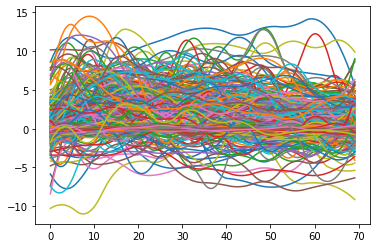

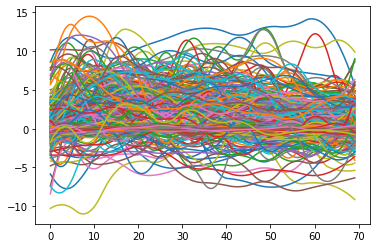

In [ ]:
all_fd_basis.plot()

## Outlier detection

We had an outlier problem before filling in missing values, here we tried to find a solution to it, but as turned out that the problem is in the videos that start not from the begining but from ~10th frame (because they had low confidence scores there), by extrapolating the boundaries we eliminate this problem, thus we do not need this step.

# Pipeline for all values

In [ ]:
stypes = {'gen_q': 'polar_q', 'part_q': 'wh_q', 'st':'st'}

Load data

In [ ]:
df = pd.read_csv('open_face_short.csv', sep='\t', index_col=[0,1])
df.loc[df.confidence < 0.8, ['inner_perp_dist39_42_3d_pred_mlp_8_diff','outer_perp_dist39_42_3d_pred_mlp_8_diff','pose_Rx']] = None
bfill = df[['inner_perp_dist39_42_3d_pred_mlp_8_diff','outer_perp_dist39_42_3d_pred_mlp_8_diff','pose_Rx']].bfill(axis=0)
ffill = df[['inner_perp_dist39_42_3d_pred_mlp_8_diff','outer_perp_dist39_42_3d_pred_mlp_8_diff','pose_Rx']].ffill(axis=0)
df[['inner_perp_dist39_42_3d_pred_mlp_8_diff','outer_perp_dist39_42_3d_pred_mlp_8_diff','pose_Rx']] = (bfill + ffill)/2

In [ ]:
boundaries = pd.read_csv('pos_boundaries.csv', index_col=[0])
boundaries = boundaries.iloc[:,:-2] # we also have boundaries for the wh-sign, so we do not consider it here

We will store data in dictionary form

In [ ]:
from collections import defaultdict

In [ ]:
names = ['pose_Rx', 'inner_perp_dist39_42_3d_pred_mlp_8_diff', 'outer_perp_dist39_42_3d_pred_mlp_8_diff']

In [ ]:
video_names = df.index.levels[0].unique()
l = video_names.shape[0]

In [ ]:
variables = defaultdict(list)
for name in names:
    for video_name in video_names:
        data = df.loc[video_name, name]
        variables[name].append(data.values)

In [ ]:
frameids = []
for video_name in video_names:
    data = df.loc[video_name].index
    frameids.append(data.values)

sentence_type = []
speaker_ids = []
sentences = []
durations = []
for video_name in video_names:
    sentence_type.append(df.loc[video_name, 'sType'].iloc[0])
    speaker_ids.append(df.loc[video_name, 'speaker'].iloc[0])
    sentences.append(df.loc[video_name, 'sentence'].iloc[0])
    durations.append(df.loc[video_name].index.values.max())
sentence_type = np.asarray(sentence_type)
speaker_ids = np.asarray(speaker_ids)
sentences = np.asarray(sentences)
norm_rng = (0,np.mean(durations))
durations = np.asarray(durations)

t_norms = (frameids / durations) * np.mean(durations)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



When we have outliers we can drop them like this. But now nothing is dropped.

In [ ]:
sentences_out = []
for i, frames in enumerate(frameids):
    if min(frames) > 0:
        sentences_out.append(i)
good_ix = np.ones(l)
good_ix[sentences_out] = 0

In [ ]:
len(sentences_out)

0

Creating FDataGrid objects

In [ ]:
def create_fds(data, t_norms):
    fds = [
        skfda.FDataGrid(
            data_matrix=d,
            grid_points=t_norms[i],
        )
        for i, d in enumerate(data)
    ]
    return fds

In [ ]:
fds_variables = {name: create_fds(data, t_norms) for name, data in variables.items()}

Smoothing with kernels if needed

In [ ]:
def smooth_fds(fds, smoother):
    fds_smooth = []
    for fd in fds:
        fd_smooth = smoother.fit_transform(fd)
        fds_smooth.append(fd_smooth)
    return fds_smooth

In [ ]:
smoother = ks.KNeighborsSmoother(smoothing_parameter=5)
fds_smooth_variables = {name: smooth_fds(data, smoother) for name, data in fds_variables.items()}

Turn FDataGrid to FDataBasis

In [ ]:
def to_basis_fds(fds, basis, w_basis_smoother=False):
    if w_basis_smoother:
        smoother = BasisSmoother(basis, smoothing_parameter=1, return_basis=True)
        fds_basis = [
            smoother.fit_transform(fd)
            for fd in fds
        ]
    else:
        fds_basis = [
            fd.to_basis(basis)
            for fd in fds
        ]
    all_fd_basis = fds_basis[0]
    for fd_basis in fds_basis[1:]:
        all_fd_basis = all_fd_basis.concatenate(fd_basis)
    all_fd_basis.extrapolation = 'bounds'
    return all_fd_basis

In [ ]:
basis = skfda.representation.basis.BSpline(domain_range=norm_rng, n_basis=14, order=3)

# with kernel smoothing
# fd_basis_variables = {name: to_basis_fds(data, basis) for name, data in fds_smooth_variables.items()}

# with basis smoothing
fd_basis_variables = {name: to_basis_fds(data, basis, w_basis_smoother=True) for name, data in fds_variables.items()}

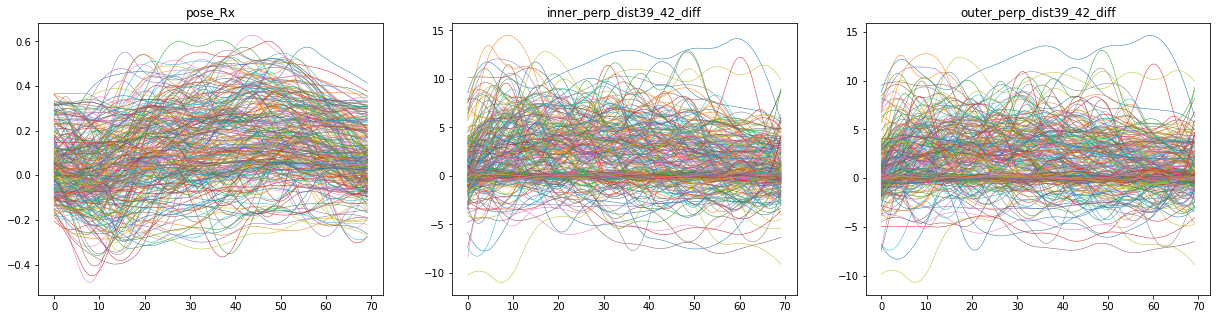

In [ ]:
fig, axes = plt.subplots(1, len(names), figsize=(7*len(names), 5))
for i, (name, data) in enumerate(fd_basis_variables.items()):
    data[good_ix == 1].plot(axes=axes[i], linewidth=0.5)
    axes[i].set_title(name.replace('_3d_pred_mlp_8', ''))

Landmark registration

In [ ]:
def align_landmarks(fd_basis, boundaries, landmark_location):
    fd_registered = skfda.preprocessing.registration.landmark_registration(fd_basis, landmarks=boundaries, location=landmark_location)
    return fd_registered

In [ ]:
boundaries = boundaries.loc[video_names]
norm_boundaries = (boundaries.values.T / np.array(durations)) * np.mean(durations)
norm_boundaries = norm_boundaries.T
landmark_location = norm_boundaries.mean(axis=0)
fd_registered_variables = {name: align_landmarks(data, norm_boundaries, landmark_location) for name, data in fd_basis_variables.items()}

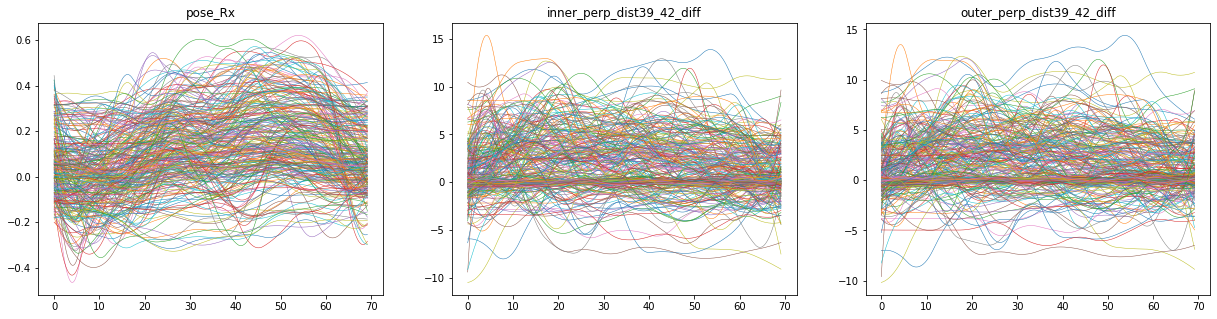

In [ ]:
fig, axes = plt.subplots(1, len(names), figsize=(7*len(names), 5))
for i, (name, data) in enumerate(fd_registered_variables.items()):
    data[good_ix == 1].plot(axes=axes[i], linewidth=0.5)
    axes[i].set_title(name.replace('_3d_pred_mlp_8', ''))

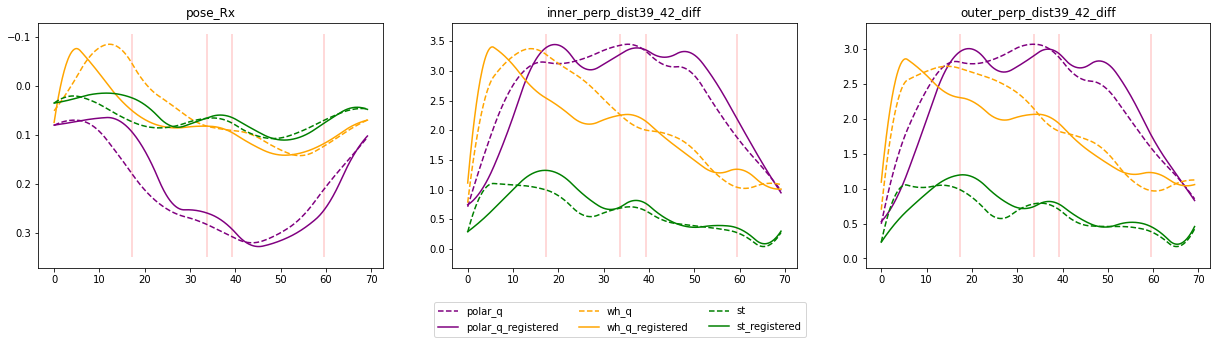

In [ ]:
fig, axes = plt.subplots(1, len(names), figsize=(7*len(names),5))
colors = ['purple','orange','green']
for i, name in enumerate(names):
    for j, stype in enumerate(np.unique(sentence_type)):
        mask = (sentence_type == stype) & (good_ix == 1)
        fd = fd_basis_variables[name][mask].mean()
        fd_shift = fd_registered_variables[name][mask].mean()
        fd.plot(axes=axes[i], color=colors[j], linestyle='--', label=f'{stypes[stype]}')
        fd_shift.plot(axes=axes[i], color=colors[j], label=f'{stypes[stype]}_registered')
    axes[i].vlines(landmark_location, *axes[i].get_ylim(), color='r', alpha=0.2)
    axes[i].set_title(name.replace('_3d_pred_mlp_8', ''))
axes[0].invert_yaxis()
fig.legend(plt.gca().lines, ['polar_q', 'polar_q_registered', 'wh_q', 'wh_q_registered', 'st', 'st_registered'], ncol=3, bbox_to_anchor=(0.41, 0), loc='lower center')
fig.subplots_adjust(bottom=0.2)

Perform FPCA

In [ ]:
def get_fpca(fd, n=5):
    fpca = FPCA(n_components=n)
    fpca = fpca.fit(fd)
    return fpca

In [ ]:
fpca_variables = {name: get_fpca(data[good_ix == 1]) for name, data in fd_registered_variables.items()}

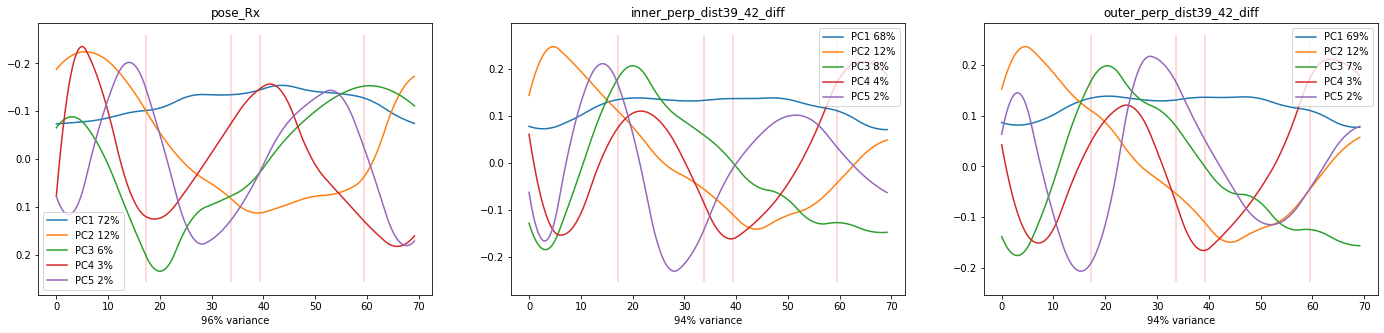

In [ ]:
fig, axes = plt.subplots(1, len(names), figsize=(8*len(names),5))
colors = ['purple','orange','green']
for i, name in enumerate(names):
    fpca = fpca_variables[name]
    fpca.components_.plot(axes=axes[i])
    axes[i].legend(['PC{} {:.0%}'.format(j+1, component_variance) for j, component_variance in enumerate(fpca.explained_variance_ratio_)])
    axes[i].vlines(landmark_location, *fig.axes[i].get_ylim(), color='r', alpha=0.2)
    axes[i].set_title(name.replace('_3d_pred_mlp_8', ''))
    axes[i].set_xlabel('{:.0%} variance'.format(fpca.explained_variance_ratio_.sum()))

axes[0].invert_yaxis()

Get FPCA scores for each sentence

In [ ]:
def get_scores(fd, fpca):
    scores = fpca.transform(fd)
    return scores

In [ ]:
scores_variables = {name: get_scores(data[good_ix == 1], fpca_variables[name]) for name, data in fd_registered_variables.items()}

Plot perturbation graphs

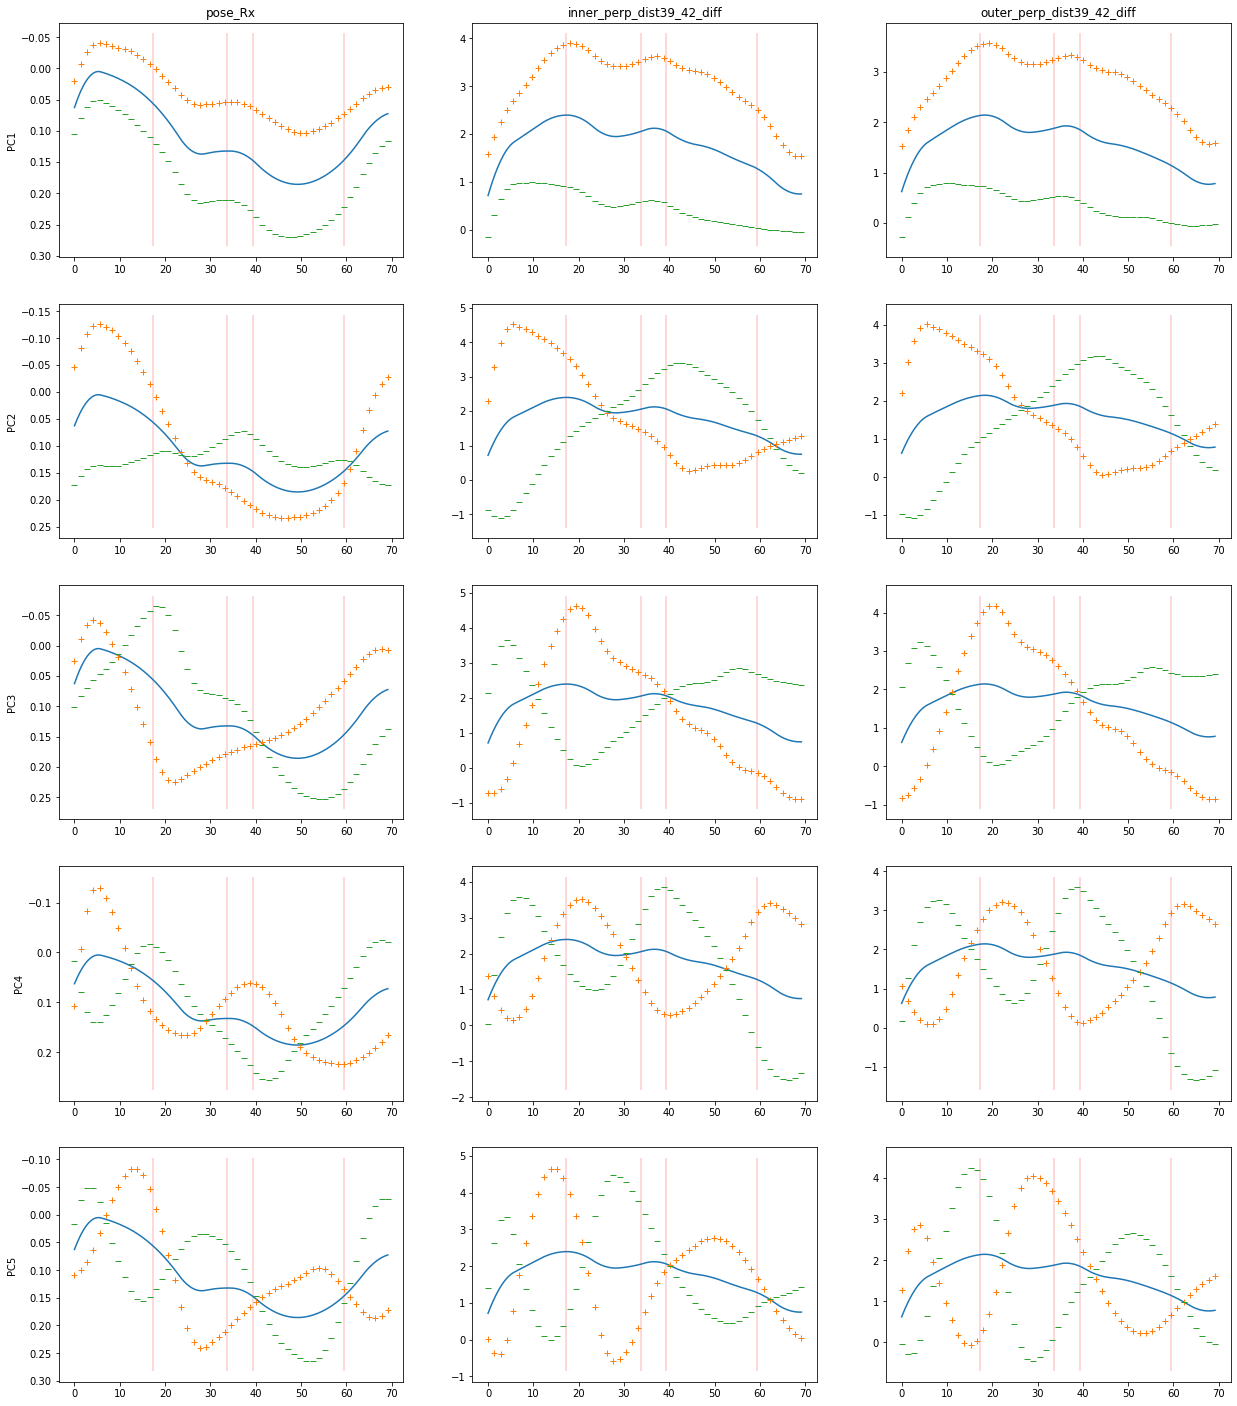

In [ ]:
fig, axes = plt.subplots(5, len(names), figsize=(7*len(names),5*5))
for i, name in enumerate(names):
    fpca = fpca_variables[name]
    multiple = float(np.std(scores_variables[name]))
    plot_fpca_perturbation_graphs(fpca.mean_,
                                  fpca.components_,
                                  multiple=multiple,
                                  axes=axes[:,i].tolist())
    for ax in axes[:,i]:
        ax.set_title('')
        ax.vlines(landmark_location, *ax.get_ylim(), color='r', alpha=0.2)
    axes[0,i].set_title(name.replace('_3d_pred_mlp_8', ''))

for i in range(5):
    axes[i,0].set_ylabel(f'PC{i+1}')
    axes[i,0].invert_yaxis()

colors = {'#ff7f0e':'--', '#2ca02c':'-.'}
for ax in axes.flatten():
    for ln in ax.get_lines():
        c = ln.get_color()
        if c == '#ff7f0e':
            ln.set_marker('+')
            ln.set_linestyle(' ')
            ln.set_markevery(10)
        elif c == '#2ca02c':
            ln.set_marker('_')
            ln.set_linestyle(' ')
            ln.set_markevery(10)

## Plot PC scores opposite each other

In [ ]:
for i, name in enumerate(names):
    fpca = fpca_variables[name]
    scores = scores_variables[name]
    labels = {
        str(i): f"PC {i+1} ({var:.0%})"
        for i, var in enumerate(fpca.explained_variance_ratio_ )
    }

    fig = px.scatter_matrix(
        scores,
        labels=labels,
        dimensions=range(5),
        color=[stypes[stype] for stype in sentence_type[good_ix == 1]],
        opacity=0.5,
        title=name.replace('_3d_pred_mlp_8', ''),
        width=800, height=800
    )
    fig.update_traces(diagonal_visible=False)
    fig.show()

In [ ]:
deaf = ['deaf'  if speaker in ['alt', 'kar', 'makh', 'mira', 'tanya'] else 'hearing' for speaker in speaker_ids]

In [ ]:
for i, name in enumerate(names):
    fpca = fpca_variables[name]
    scores = scores_variables[name]
    labels = {
        str(i): f"PC {i+1} ({var:.0%})"
        for i, var in enumerate(fpca.explained_variance_ratio_ )
    }

    fig = px.scatter_matrix(
        scores,
        labels=labels,
        dimensions=range(5),
        color=deaf,
        title=name.replace('_3d_pred_mlp_8', ''),
        width=800, height=800
    )
    fig.update_traces(diagonal_visible=False)
    fig.show()

## Save scores

In [ ]:
for name, score in scores_variables.items():
    df = pd.DataFrame(score, columns=[f'PC_{i+1}' for i in range(score.shape[1])], index=video_names[good_ix == 1])
    df['sType'] = sentence_type[good_ix == 1]
    df['deaf'] = np.asarray(deaf)[good_ix == 1]
    df['speaker_id'] = speaker_ids[good_ix == 1]
    df['sentence'] = sentences[good_ix == 1]
    df.to_csv(f'{name}_fpca_scores.csv')

## Look at significant PC

After statistical analysis we have the information about significant PCs and we explore them visualy here

### Vertical head alignemnt

In [ ]:
pose_rx_scores = scores_variables['pose_Rx']

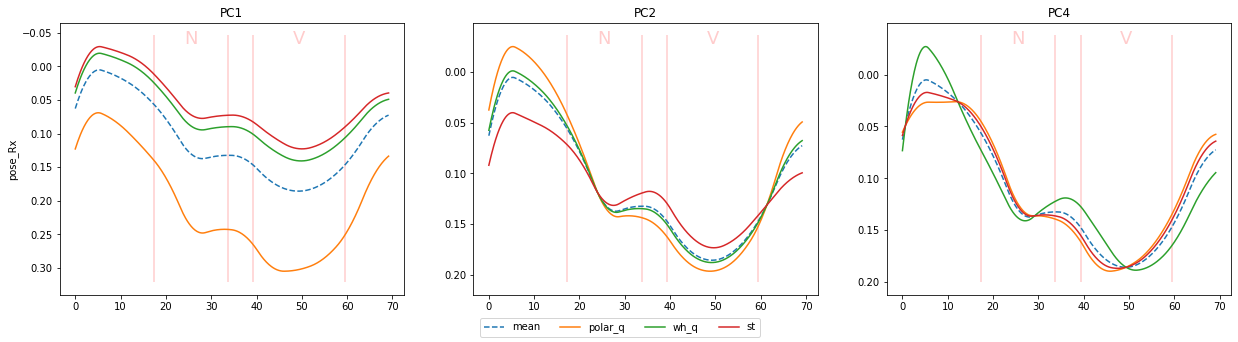

In [ ]:
pose_significant = [0,1,3]
fig, axes = plt.subplots(1, 3, figsize=(7*3, 5))
for i, component in enumerate(pose_significant):
    fpca = fpca_variables['pose_Rx']
    fpca.mean_.plot(axes=axes[i], linestyle='--', label='mean')
    for stype in pose_rx_scores.sType.unique():
        mean_score = np.mean(pose_rx_scores.loc[pose_rx_scores.sType == stype].iloc[:,component])
        curve = fpca.mean_ + mean_score * fpca.components_[component:component+1]
        curve.plot(axes=axes[i], label=stypes[stype])
    axes[i].set_title(f'PC{component+1}')

axes[0].set_ylabel('pose_Rx')
for ax in axes:
    # ax.set_title('')
    ax.invert_yaxis()
    y_lim = ax.get_ylim()
    height = np.abs(y_lim[0] - y_lim[1])
    ax.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
    ax.text(np.mean(landmark_location[:2]), y_lim[1]+height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='bottom')
    ax.text(np.mean(landmark_location[2:]), y_lim[1]+height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='bottom')

fig.legend(axes[0].lines, [l.get_label() for l in axes[0].lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')

Find mean scores

In [ ]:
component = 4
for deaf in pose_rx_scores.deaf.unique():
    mean_score = np.mean(pose_rx_scores.loc[pose_rx_scores.deaf == deaf].iloc[:,component])
    print(deaf, '{:.3}'.format(mean_score))

deaf -0.0469
hearing 0.0645


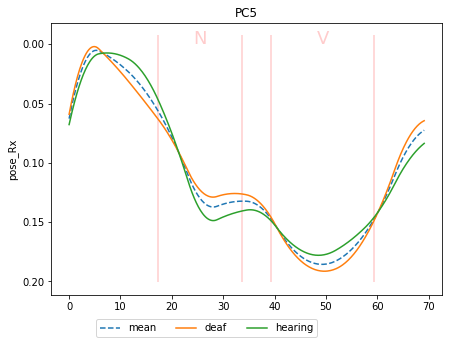

In [ ]:
pose_deaf_significant = [4]
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
for i, component in enumerate(pose_deaf_significant):
    fpca = fpca_variables['pose_Rx']
    fpca.mean_.plot(axes=axes, linestyle='--', label='mean')
    for deaf in pose_rx_scores.deaf.unique():
        mean_score = np.mean(pose_rx_scores.loc[pose_rx_scores.deaf == deaf].iloc[:,component])
        curve = fpca.mean_ + mean_score * fpca.components_[component]
        curve.plot(axes=axes, label=deaf)
    axes.set_title(f'PC{component+1}')

axes.set_ylabel('pose_Rx')
axes.invert_yaxis()
y_lim = axes.get_ylim()
height = np.abs(y_lim[0] - y_lim[1])
axes.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
axes.text(np.mean(landmark_location[:2]), y_lim[1]+height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='bottom')
axes.text(np.mean(landmark_location[2:]), y_lim[1]+height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='bottom')

fig.legend(axes.lines, [l.get_label() for l in axes.lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')

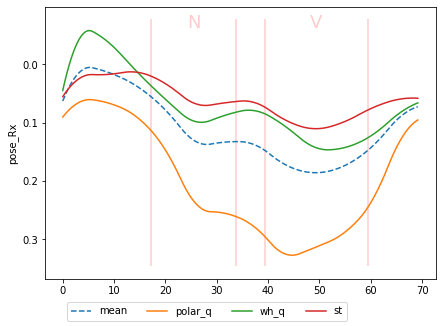

In [ ]:
pose_significant = [0,1,3]
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
fpca = fpca_variables['pose_Rx']
fpca.mean_.plot(axes=axes, linestyle='--', label='mean')
for stype in pose_rx_scores.sType.unique():
    mean_scores = np.mean(pose_rx_scores.loc[pose_rx_scores.sType == stype].iloc[:,pose_significant], axis=0)
    mean_curve = fpca.mean_
    for i, score in enumerate(mean_scores):
        mean_curve += score * fpca.components_[pose_significant[i]]
    mean_curve.plot(axes=axes, label=stypes[stype])

axes.set_ylabel('pose_Rx')
axes.invert_yaxis()
y_lim = axes.get_ylim()
height = np.abs(y_lim[0] - y_lim[1])
axes.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
axes.text(np.mean(landmark_location[:2]), y_lim[1]+height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='bottom')
axes.text(np.mean(landmark_location[2:]), y_lim[1]+height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='bottom')

fig.legend(axes.lines, [l.get_label() for l in axes.lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')

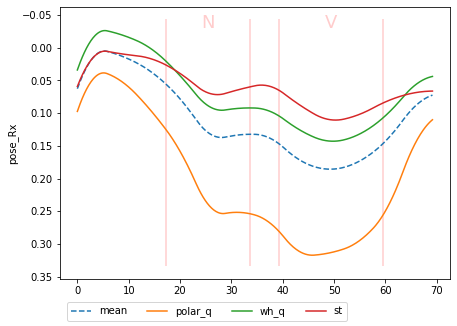

In [ ]:
pose_significant = [0,1]
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
fpca = fpca_variables['pose_Rx']
fpca.mean_.plot(axes=axes, linestyle='--', label='mean')
for stype in pose_rx_scores.sType.unique():
    mean_scores = np.mean(pose_rx_scores.loc[pose_rx_scores.sType == stype].iloc[:,pose_significant], axis=0)
    mean_curve = fpca.mean_
    for i, score in enumerate(mean_scores):
        mean_curve += score * fpca.components_[pose_significant[i]]
    mean_curve.plot(axes=axes, label=stypes[stype])

axes.set_ylabel('pose_Rx')
axes.invert_yaxis()
y_lim = axes.get_ylim()
height = np.abs(y_lim[0] - y_lim[1])
axes.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
axes.text(np.mean(landmark_location[:2]), y_lim[1]+height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='bottom')
axes.text(np.mean(landmark_location[2:]), y_lim[1]+height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='bottom')

fig.legend(axes.lines, [l.get_label() for l in axes.lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')

### Eyebrow distances

In [ ]:
inner_scores = scores_variables['inner_perp_dist39_42_3d_pred_mlp_8_diff']
outer_scores = scores_variables['outer_perp_dist39_42_3d_pred_mlp_8_diff']

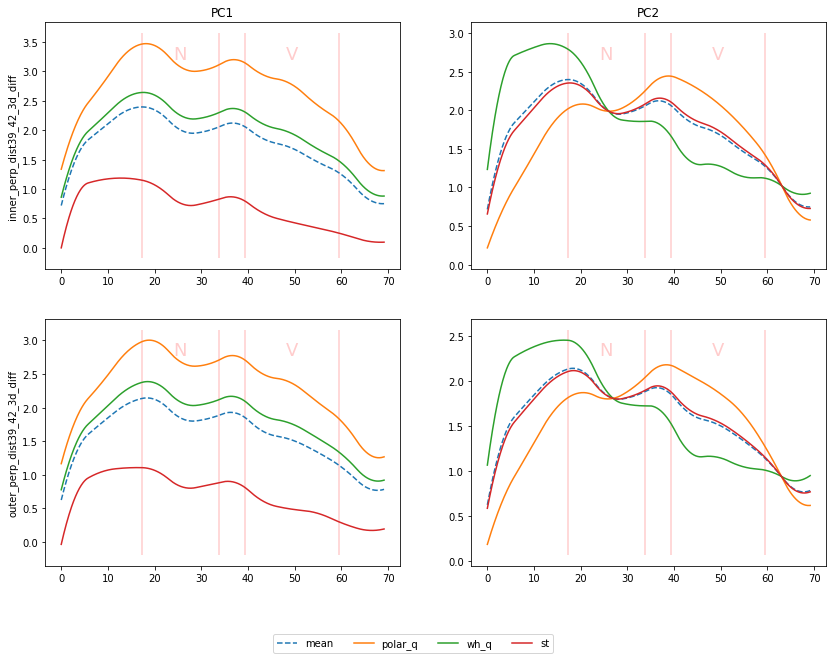

In [ ]:
brow_significant = [0,1]
fig, axes = plt.subplots(2, 2, figsize=(7*2, 10))
for j, brow in enumerate([inner_scores, outer_scores]):
    for i, component in enumerate(brow_significant):
        fpca = fpca_variables[names[j+1]]
        fpca.mean_.plot(axes=axes[j,i], linestyle='--', label='mean')
        for stype in brow.sType.unique():
            mean_score = np.mean(brow.loc[brow.sType == stype].iloc[:,component])
            curve = fpca.mean_ + mean_score * fpca.components_[component:component+1]
            curve.plot(axes=axes[j,i], label=stypes[stype])
        axes[0,i].set_title(f'PC{component+1}')

    axes[j,0].set_ylabel(['inner_perp_dist39_42_3d_diff', 'outer_perp_dist39_42_3d_diff'][j])
for ax in axes.flatten():
    y_lim = ax.get_ylim()
    height = np.abs(y_lim[0] - y_lim[1])
    ax.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
    ax.text(np.mean(landmark_location[:2]), y_lim[1]-height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')
    ax.text(np.mean(landmark_location[2:]), y_lim[1]-height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')

fig.legend(axes[0,0].lines, [l.get_label() for l in axes[0,0].lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')

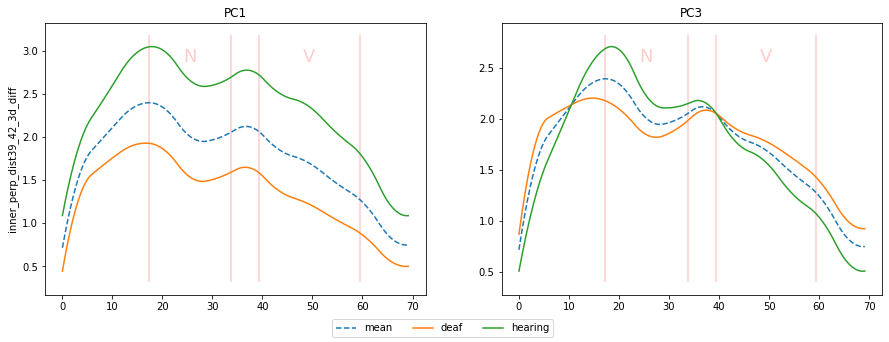

In [ ]:
inner_deaf_significant = [0,2]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, component in enumerate(inner_deaf_significant):
    fpca = fpca_variables[names[1]]
    fpca.mean_.plot(axes=axes[i], linestyle='--', label='mean')
    for deaf in inner_scores.deaf.unique():
        mean_score = np.mean(inner_scores.loc[inner_scores.deaf == deaf].iloc[:,component])
        curve = fpca.mean_ + mean_score * fpca.components_[component]
        curve.plot(axes=axes[i], label=deaf)
    axes[i].set_title(f'PC{component+1}')

axes[0].set_ylabel('inner_perp_dist39_42_3d_diff')
for ax in axes:
    y_lim = ax.get_ylim()
    height = np.abs(y_lim[0] - y_lim[1])
    ax.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
    ax.text(np.mean(landmark_location[:2]), y_lim[1]-height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')
    ax.text(np.mean(landmark_location[2:]), y_lim[1]-height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')

fig.legend(axes[0].lines, [l.get_label() for l in axes[0].lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')

Find mean scores

In [ ]:
components = [0,2]
for component in components:
    print(component)
    for deaf in inner_scores.deaf.unique():
        mean_score = np.mean(inner_scores.loc[inner_scores.deaf == deaf].iloc[:,component])
        print('inner', deaf, '{:.3}'.format(mean_score))
    for deaf in outer_scores.deaf.unique():
        mean_score = np.mean(outer_scores.loc[outer_scores.deaf == deaf].iloc[:,component])
        print('outer', deaf, '{:.3}'.format(mean_score))

0
inner deaf -3.48
inner hearing 4.79
outer deaf -3.73
outer hearing 5.13
2
inner deaf -1.19
inner hearing 1.63
outer deaf -0.889
outer hearing 1.22


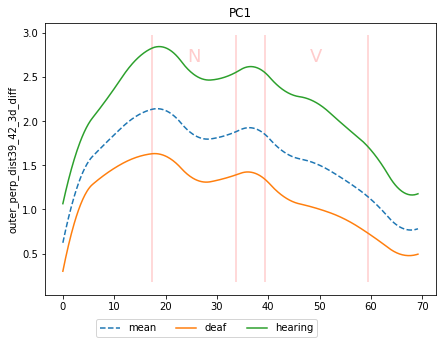

In [ ]:
outer_deaf_significant = [0]
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
for i, component in enumerate(outer_deaf_significant):
    fpca = fpca_variables[names[2]]
    fpca.mean_.plot(axes=axes, linestyle='--', label='mean')
    for deaf in outer_scores.deaf.unique():
        mean_score = np.mean(outer_scores.loc[outer_scores.deaf == deaf].iloc[:,component])
        curve = fpca.mean_ + mean_score * fpca.components_[component]
        curve.plot(axes=axes, label=deaf)
    axes.set_title(f'PC{component+1}')

axes.set_ylabel('outer_perp_dist39_42_3d_diff')
y_lim = axes.get_ylim()
height = np.abs(y_lim[0] - y_lim[1])
axes.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
axes.text(np.mean(landmark_location[:2]), y_lim[1]-height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')
axes.text(np.mean(landmark_location[2:]), y_lim[1]-height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')

fig.legend(axes.lines, [l.get_label() for l in axes.lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')

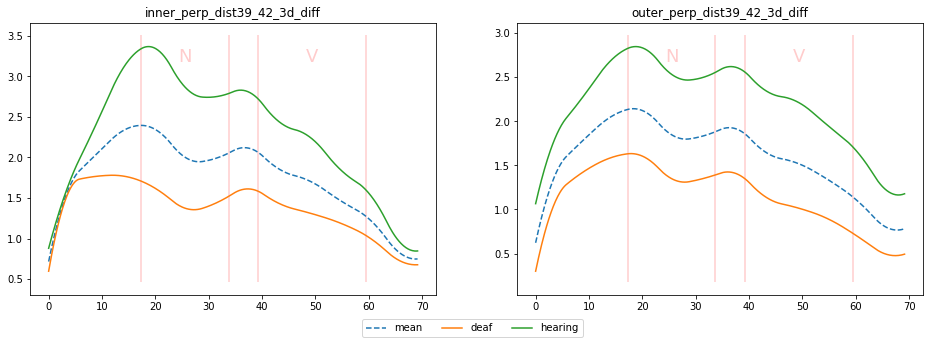

In [ ]:
brow_deaf_significant = [[0,2],[0]]
fig, axes = plt.subplots(1, 2, figsize=(8*2, 5))
for j, brow in enumerate([inner_scores, outer_scores]):
    fpca = fpca_variables[names[j+1]]
    fpca.mean_.plot(axes=axes[j], linestyle='--', label='mean')
    for deaf in brow.deaf.unique():
        mean_scores = np.mean(brow.loc[brow.deaf == deaf].iloc[:,brow_deaf_significant[j]], axis=0)
        mean_curve = fpca.mean_
        for i, score in enumerate(mean_scores):
            mean_curve += score * fpca.components_[brow_significant[j][i]]
        mean_curve.plot(axes=axes[j], label=deaf)
    axes[j].set_title(['inner_perp_dist39_42_3d_diff', 'outer_perp_dist39_42_3d_diff'][j])

for ax in axes.flatten():
    y_lim = ax.get_ylim()
    height = np.abs(y_lim[0] - y_lim[1])
    ax.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
    ax.text(np.mean(landmark_location[:2]), y_lim[1]-height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')
    ax.text(np.mean(landmark_location[2:]), y_lim[1]-height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')

fig.legend(axes[0].lines, [l.get_label() for l in axes[0].lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')

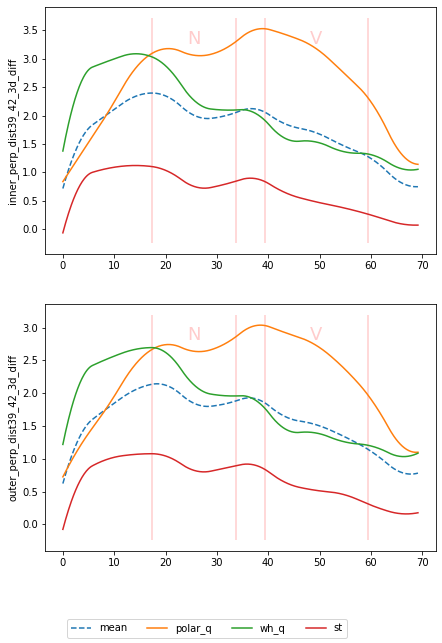

In [ ]:
brow_significant = [0,1]
fig, axes = plt.subplots(2, 1, figsize=(7, 10))
for j, brow in enumerate([inner_scores, outer_scores]):
    fpca = fpca_variables[names[j+1]]
    fpca.mean_.plot(axes=axes[j], linestyle='--', label='mean')
    for stype in brow.sType.unique():
        mean_scores = np.mean(brow.loc[brow.sType == stype].iloc[:,brow_significant], axis=0)
        mean_curve = fpca.mean_
        for i, score in enumerate(mean_scores):
            mean_curve += score * fpca.components_[brow_significant[i]]
        mean_curve.plot(axes=axes[j], label=stypes[stype])
    axes[j].set_ylabel(['inner_perp_dist39_42_3d_diff', 'outer_perp_dist39_42_3d_diff'][j])

for ax in axes.flatten():
    y_lim = ax.get_ylim()
    height = np.abs(y_lim[0] - y_lim[1])
    ax.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
    ax.text(np.mean(landmark_location[:2]), y_lim[1]-height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')
    ax.text(np.mean(landmark_location[2:]), y_lim[1]-height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')

fig.legend(axes[0].lines, [l.get_label() for l in axes[0].lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')

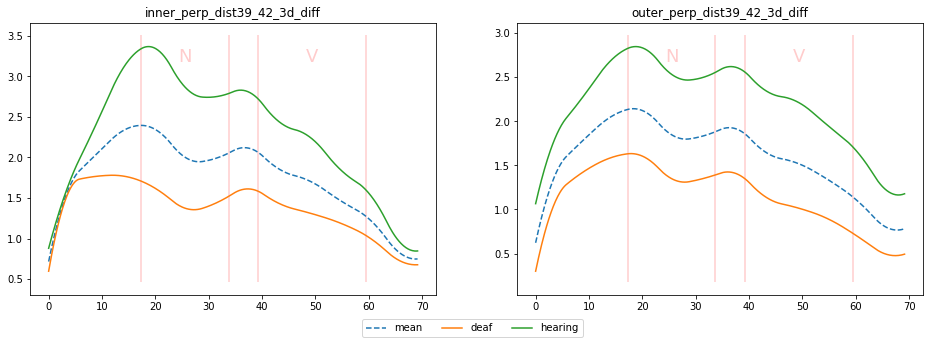

In [ ]:
brow_significant = [[0,2],[0]]
fig, axes = plt.subplots(1, 2, figsize=(8*2, 5))
for j, brow in enumerate([inner_scores, outer_scores]):
    fpca = fpca_variables[names[j+1]]
    fpca.mean_.plot(axes=axes[j], linestyle='--', label='mean')
    for deaf in brow.deaf.unique():
        mean_scores = np.mean(brow.loc[brow.deaf == deaf].iloc[:,brow_significant[j]], axis=0)
        mean_curve = fpca.mean_
        for i, score in enumerate(mean_scores):
            mean_curve += score * fpca.components_[brow_significant[j][i]]
        mean_curve.plot(axes=axes[j], label=deaf)
    axes[j].set_title(['inner_perp_dist39_42_3d_diff', 'outer_perp_dist39_42_3d_diff'][j])

for ax in axes.flatten():
    y_lim = ax.get_ylim()
    height = np.abs(y_lim[0] - y_lim[1])
    ax.vlines(landmark_location, *y_lim, color='r', alpha=0.2)
    ax.text(np.mean(landmark_location[:2]), y_lim[1]-height*0.05, 'N', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')
    ax.text(np.mean(landmark_location[2:]), y_lim[1]-height*0.05, 'V', fontsize=18, color='r', alpha=0.2, horizontalalignment='center', verticalalignment='top')

fig.legend(axes[0].lines, [l.get_label() for l in axes[0].lines], ncol=4, bbox_to_anchor=(0.41, 0), loc='lower center')